# 311 Data Exploratory Data Analysis


## References:
Neighborhoods Geojson: https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from PIL import Image

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import confusion_matrix

% matplotlib inline

In [2]:
# Using the first 60000 data points
# Limited due to computational time and disc space
files = glob.glob('bw_pickles/bw_[0-9]*.gzde')
#print(files)
dim1, dim2, dim3 = 128, 128, 3

df = pd.concat([pd.read_pickle(fp, compression='gzip') for fp in files])
df.sort_index(inplace=True)

columns = list(df.columns)
columns = [column.lower().replace(' ', '_') for column in columns]
df.columns = columns
# Drop columns without an image - won't be using for analysis on images
df.dropna(subset=['image'], inplace=True)
# Drop image column for space
df.drop(columns=['image'], inplace=True)

df['updated'] = pd.to_datetime(df['updated'])
df['opened'] = pd.to_datetime(df['opened'])
df['closed'] = pd.to_datetime(df['closed'])
df['month'] = df['month'].astype('int16')
df['year'] = df['year'].astype('int16')
df['caseid'] = df['caseid'].astype('int')
df['neighborhood'] = df['neighborhood'].astype('category')
df['police_district'] = df['police_district'].astype('category')
df['street'] = df['street'].astype('category')
df['category'] = df['category'].astype('category')
df['status'] = df['status'].astype('category')
df['responsible_agency'] = df['responsible_agency'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('str')
df['street'] = df['street'].astype('str')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63634 entries, 0 to 63999
Data columns (total 22 columns):
caseid                 63634 non-null int64
opened                 63634 non-null datetime64[ns]
closed                 62424 non-null datetime64[ns]
updated                63634 non-null datetime64[ns]
status                 63634 non-null category
status_notes           41153 non-null object
responsible_agency     63634 non-null category
category               63634 non-null category
request_type           63634 non-null object
request_details        62422 non-null object
address                63634 non-null object
street                 63634 non-null object
supervisor_district    63630 non-null float64
neighborhood           63634 non-null object
police_district        63485 non-null category
latitude               63634 non-null float64
longitude              63634 non-null float64
point                  63634 non-null object
source                 63634 non-null object
me

In [4]:
# Can't convert supervisor district to ints because of nan values
df.supervisor_district.unique()

array([ 6.,  8.,  4.,  9.,  5., 10.,  3., 11.,  2.,  1.,  7.,  0., nan])

In [5]:
def categorize(df):
    if df['category'] == 'Street and Sidewalk Cleaning':
        if (df['request_type'] == 'Transit_shelter_platform' or
            df['request_type'] == 'Missed_Route_Mechanical_Sweeping'):
            return 'General Cleaning'
        elif df['request_type'] == 'City_garbage_can_overflowing':
            return 'Litter Receptacles'
        elif (df['request_type'] == 'Human Waste' or
              df['request_type'] == 'Medical Waste'):
            return 'Human or Medical Waste'
        elif df['request_type'] == 'Automotive':
            return 'Vehicle'
        else:
            return df['request_type']
    elif ('General' in df['category']) or ('Catch Basin' in df['category']):
        return 'Other'
    elif ((df['category'] == 'Street Defects') or 
          (df['category'] == 'Sidewalk or Curb') or 
          (df['category'] == 'Blocked Street or SideWalk')):
        return 'Street and Sidewalk Issues'
    elif ((df['category'] == 'Abandoned Vehicle') or 
          (df['category'] == 'Parking Enforcement')):
        return 'Vehicle'
    elif (df['category'] == 'Illegal Postings' or
          df['category'] == 'Sign Repair'):
        return 'Signs - Illegal Postings and Repair'
    else:
        return df['category']

In [6]:
df['group'] = df.apply(categorize, axis=1)
print(df['group'].unique())
print(df['group'].nunique())

['Graffiti' 'Vehicle' 'General Cleaning' 'Litter Receptacles'
 'Hazardous Materials' 'Street and Sidewalk Issues'
 'Rec and Park Requests' 'Bulky Items' 'Encampments'
 'Human or Medical Waste' 'Other' 'Signs - Illegal Postings and Repair'
 'Tree Maintenance' 'Sewer Issues' 'Streetlights' 'Damaged Property']
16


In [7]:
df.head()

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,neighborhood,police_district,latitude,longitude,point,source,media_url,year,month,group
0,7228536,2017-06-06 07:31:38,2017-06-10 12:26:23,2017-06-10 12:26:23,Closed,SES Graffiti Crew - Paint - Box - Sub Panel -...,DPW Ops Queue,Graffiti,Graffiti on Signal_box,Signal_box - Not_Offensive,...,South of Market,SOUTHERN,37.774734,-122.400620,"(37.7747345, -122.40061951)",Mobile/Open311,http://mobile311.sfgov.org/reports/7228536/photos,2017,6,Graffiti
1,9848318,2018-11-25 13:15:00,2018-11-25 14:04:15,2018-11-25 14:04:15,Closed,Officer responded to request under CAD # 18329...,Parking Enforcement Dispatch Queue,Parking Enforcement,Other_Illegal_Parking,Silver - Civic - 5xcs051,...,Tenderloin,TENDERLOIN,37.783645,-122.410763,"(37.78364452, -122.41076323)",Mobile/Open311,http://mobile311.sfgov.org/reports/9848318/photos,2018,11,Vehicle
2,9849482,2018-11-25 19:32:40,2019-02-27 21:30:07,2019-02-27 21:30:07,Closed,Per process - cases are closed 10 days after a...,Clear Channel - Transit Queue,Street and Sidewalk Cleaning,Transit_shelter_platform,Transit_shelter_platform,...,Rincon Hill,SOUTHERN,37.785531,-122.396656,"(37.7855311, -122.3966557)",Mobile/Open311,http://mobile311.sfgov.org/reports/9849482/photos,2018,11,General Cleaning
3,9681555,2018-10-16 17:25:00,2018-10-20 16:24:00,2018-10-20 16:24:00,Closed,NaN,DPW Ops Queue,Graffiti,Graffiti on Sidewalk_in_front_of_property,Sidewalk_in_front_of_property - Not_Offensive,...,Duboce Triangle,PARK,37.766496,-122.431225,"(37.76649554, -122.43122539)",Mobile/Open311,http://mobile311.sfgov.org/reports/9681555/photos,2018,10,Graffiti
4,9253531,2018-07-11 14:21:09,2018-07-12 18:33:00,2018-07-12 18:33:00,Closed,NaN,DPW Ops Queue,Litter Receptacles,Other_garbage_can_repair,NaN,...,Outer Sunset,TARAVAL,37.763896,-122.509486,"(37.76389604, -122.50948554)",Mobile/Open311,http://mobile311.sfgov.org/reports/9253531/photos,2018,7,Litter Receptacles


In [8]:
df.caseid.nunique()

63634

In [9]:
# Quick check for duplicate case id's
df.groupby('caseid')['status'].count().sort_values(ascending=False)[0:5]

caseid
10300761    1
8141293     1
8142082     1
8142011     1
8141951     1
Name: status, dtype: int64

In [10]:
df.status_notes.unique()

array(['SES Graffiti Crew  - Paint - Box - Sub Panel - High Voltage',
       'Officer responded to request under CAD # 183291647. Unable to Locate.',
       'Per process - cases are closed 10 days after assignment.', ...,
       'duplicate request of 2106515', '- NRV # 1103061,',
       '5/29/18 inspected property will transfer to other agency to abate. gd PROFANITY ON SIDE OF PROPERTY..abated by Public.gd'],
      dtype=object)

In [11]:
# Checking date range, should all be in 2017 and 2018
print(df.opened.min())
print(df.opened.max())

2017-01-01 00:28:33
2018-12-31 22:14:00


In [12]:
# Checking date range, should not be before 2017
print(df.updated.min())
print(df.updated.max())

2017-01-01 14:30:05
2019-04-06 08:00:44


In [13]:
groups = df.set_index('opened').groupby('group')['caseid'].resample('Y').count().unstack()

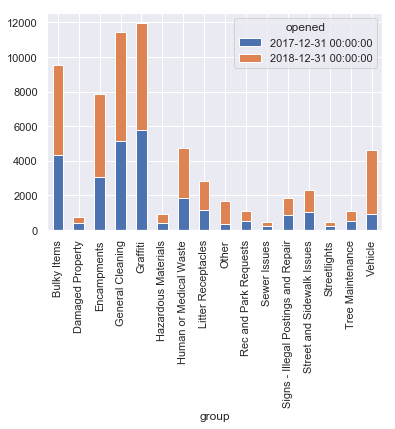

In [14]:
# Checking 2017 and 2018 proportions, vehicle increased 2018
sns.set()
groups.plot(kind='bar', stacked=True)
plt.show()

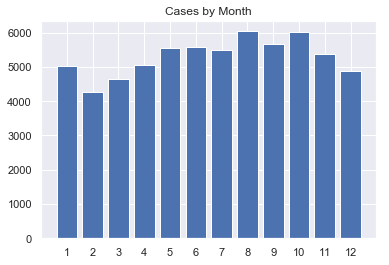

In [15]:
# Looking at the monthly distribution of reports
groups_month = df.groupby('month')['caseid'].count()
plt.title('Cases by Month')
plt.bar(x=range(1,13), height=groups_month)
plt.xticks(range(1,13))
plt.show()

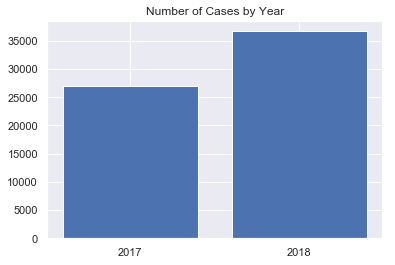

In [16]:
# Look at the yearly breakdown of reports
# More reports 
groups_year = df.groupby('year')['caseid'].count()
plt.title('Number of Cases by Year')
plt.bar(x=range(2017, 2019), height=groups_year)
plt.xticks([2017, 2018])
plt.show()

# Look into streets and nieghborhoods with a lot of requests

Unique Neighborhoods: 118
               neighborhood  count
0                   Mission   9289
1           South of Market   6848
2              Potrero Hill   2760
3           Mission Dolores   1950
4                 Chinatown   1616
5                   Bayview   1586
6              Outer Sunset   1485
7                Tenderloin   1340
8              Civic Center   1336
9   Downtown / Union Square   1235
10                Excelsior   1198
11          Duboce Triangle   1114
12           Lower Nob Hill   1072
13           Bernal Heights   1038
14                 Nob Hill   1024
15              North Beach    941
16       Financial District    938
17                   Castro    890
18             Lower Haight    874
19           Outer Richmond    854


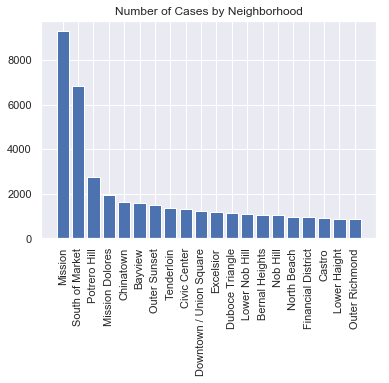

In [17]:
print('Unique Neighborhoods: {}'.format(df['neighborhood'].nunique()))
neighborhoods = df.groupby('neighborhood')['caseid'].count()
neighborhoods = neighborhoods.sort_values(ascending=False)
neighborhoods = pd.DataFrame(neighborhoods).reset_index()
neighborhoods.columns = ['neighborhood', 'count']
print(neighborhoods[0:20])
common_neighborhoods = neighborhoods.iloc[0:20]['neighborhood']

# Plot the neighborhood cases distribution
plt.title('Number of Cases by Neighborhood')
plt.bar(common_neighborhoods, height=neighborhoods['count'][0:20])
plt.xticks(rotation=90)
plt.show()

A couple of neighborhoods dominate the number of cases.

Unique Streets: 1725
                street  count
0           MISSION ST   1924
1            MARKET ST   1734
2              16TH ST   1032
3            FOLSOM ST    973
4              18TH ST    925
5              17TH ST    832
6              24TH ST    739
7              19TH ST    622
8               3RD ST    589
9        SAN BRUNO AVE    560
10  SOUTH VAN NESS AVE    552
11         HARRISON ST    527
12           BRYANT ST    523
13         VALENCIA ST    518
14             15TH ST    515
15         POTRERO AVE    477
16                 nan    472
17             25TH ST    471
18           GRANT AVE    431
19             14TH ST    428


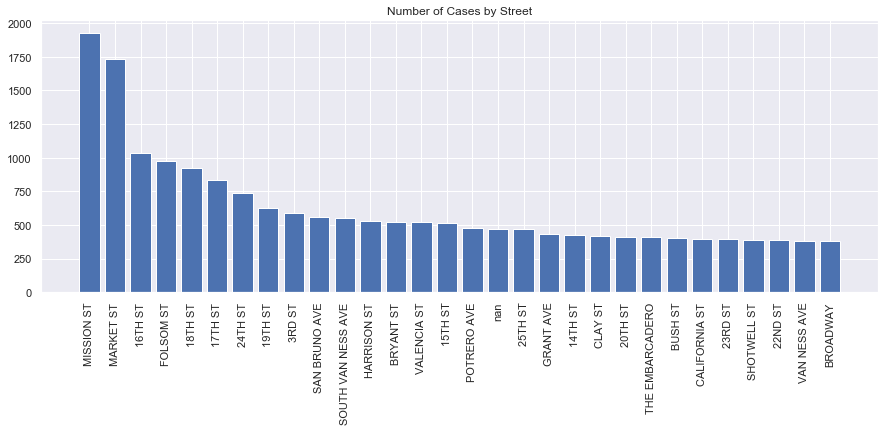

In [18]:
print('Unique Streets: {}'.format(df['street'].nunique()))
streets = df.groupby('street')['caseid'].count()
streets = streets.sort_values(ascending=False)
streets = pd.DataFrame(streets).reset_index()
streets.columns = ['street', 'count']
print(streets[0:20])
common_streets = streets.iloc[0:20]['street']

plt.figure(figsize=(15, 5))
plt.bar(streets['street'][0:30], streets['count'][0:30])
plt.xticks(rotation=90)
plt.title('Number of Cases by Street')
plt.show()

There are a lot more streets, but not quite as dominated by one street.

Unique Groups: 16
                                  group  count
0                              Graffiti  11962
1                      General Cleaning  11438
2                           Bulky Items   9553
3                           Encampments   7861
4                Human or Medical Waste   4744
5                               Vehicle   4604
6                    Litter Receptacles   2823
7            Street and Sidewalk Issues   2317
8   Signs - Illegal Postings and Repair   1859
9                                 Other   1679
10                Rec and Park Requests   1121
11                     Tree Maintenance   1072
12                  Hazardous Materials    920
13                     Damaged Property    734
14                         Sewer Issues    485
15                         Streetlights    462


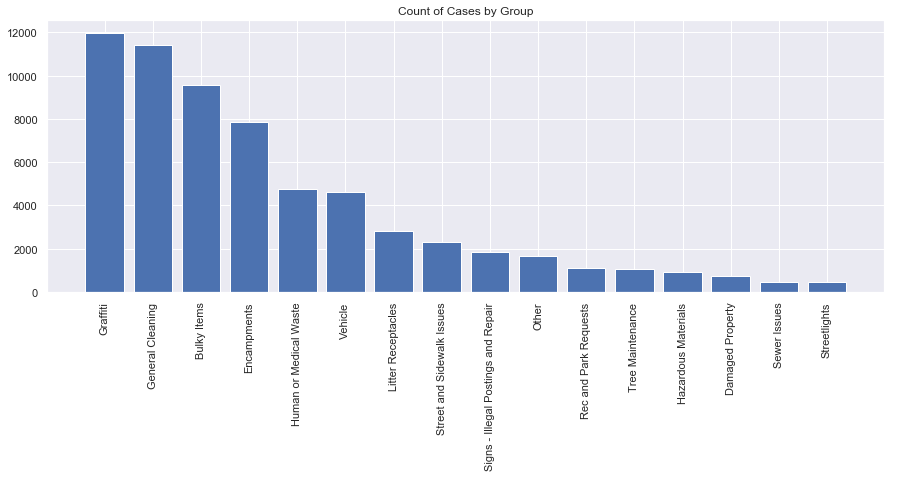

In [19]:
print('Unique Groups: {}'.format(df['group'].nunique()))
groups = df.groupby('group')['caseid'].count()
groups = groups.sort_values(ascending=False)
groups = pd.DataFrame(groups).reset_index()
groups.columns = ['group', 'count']
print(groups)
common_groups = groups.iloc[0:10]['group']

plt.figure(figsize=(15, 5))
plt.bar(groups['group'], groups['count'])
plt.title('Count of Cases by Group')
plt.xticks(rotation=90)
plt.show()

May need to combine some of the smaller groups into the Other category

## Type of Case by Street

In [20]:
# Look at the most common streets and types of complaints
street_type = df.groupby(['street', 'group'])['caseid'].count()
street_type = pd.DataFrame(street_type).reset_index()
street_type = street_type.loc[street_type['street'].isin(common_streets) == True]
street_type = street_type.loc[street_type['group'].isin(common_groups) == True]

In [21]:
street_type = street_type.pivot(index='street', 
                                columns='group', 
                                values='caseid')


In [22]:
street_type.fillna(0, inplace=True)
street_type.head()

group,Bulky Items,Encampments,General Cleaning,Graffiti,Human or Medical Waste,Litter Receptacles,Other,Signs - Illegal Postings and Repair,Street and Sidewalk Issues,Vehicle
street,,,,,,,,,,
14TH ST,56,95,77,94,33,14,8,7,13,17
15TH ST,47,161,114,77,54,12,9,7,7,11
16TH ST,70,276,174,230,93,52,21,17,19,23
17TH ST,91,151,150,172,79,18,23,37,13,44
18TH ST,57,184,118,318,96,21,19,24,15,14


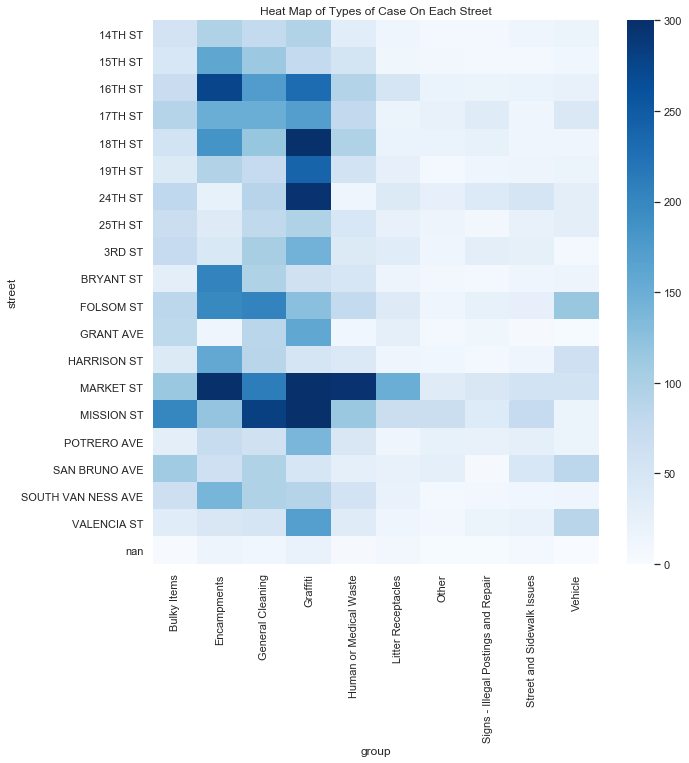

In [23]:
plt.figure(figsize=(10, 10))
sns.heatmap(street_type, vmin=0, vmax=300, cmap='Blues')
plt.title('Heat Map of Types of Case On Each Street')
plt.show()

## Type of Case by Neighborhood

In [24]:
neigh_type = df.groupby(['neighborhood', 'group'])['caseid'].count()
neigh_type = pd.DataFrame(neigh_type).reset_index()
neigh_type = neigh_type.loc[neigh_type['neighborhood'].isin(common_neighborhoods) == True]
neigh_type = neigh_type.loc[neigh_type['group'].isin(common_groups) == True]
neigh_type = neigh_type.pivot(index='neighborhood', columns='group', values='caseid')
neigh_type.fillna(0, inplace=True)
neigh_type.head()

group,Bulky Items,Encampments,General Cleaning,Graffiti,Human or Medical Waste,Litter Receptacles,Other,Signs - Illegal Postings and Repair,Street and Sidewalk Issues,Vehicle
neighborhood,,,,,,,,,,
Bayview,507,65,493,89,75,42,17,22,33,117
Bernal Heights,149,64,106,201,51,33,22,52,28,220
Castro,67,358,109,81,66,28,30,31,23,33
Chinatown,293,31,343,600,65,54,27,58,31,20
Civic Center,77,148,164,287,278,139,30,45,39,49


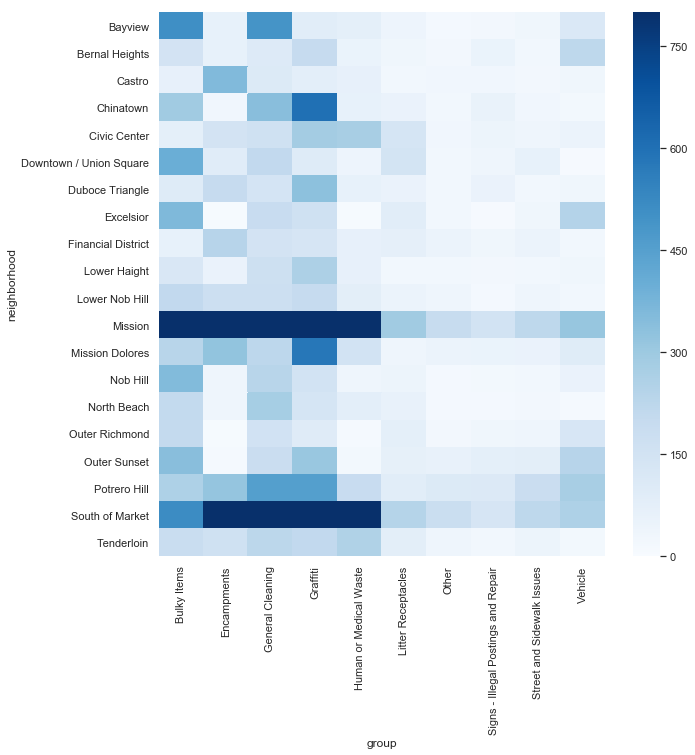

In [25]:
plt.figure(figsize=(10, 10))
sns.heatmap(neigh_type, vmin=0, vmax=800, cmap='Blues')
plt.show()

We can also see that different neighborhoods have different types of complaints.  For example, if there is a case in Excelsior, it is likely a Bulky Item pickup or a Vehicle related complaint.

## Cases by Month 
I am not looking into trends across years because I only looked at 2 years worth of data.  With more processing power or with a different sampling, it could be interesting to look at the change of types of cases reported across yearse.

In [26]:
month_type = df.groupby(['month', 'group'])['caseid'].count()
month_type = pd.DataFrame(month_type).reset_index()
#neigh_type = neigh_type.loc[neigh_type['group'].isin(common_groups) == True]
#month_type = month_type.pivot(index='month', columns='group', values='caseid')
month_type.fillna(0, inplace=True)
month_type.head()

,month,group,caseid
0,1,Bulky Items,791
1,1,Damaged Property,56
2,1,Encampments,443
3,1,General Cleaning,1008
4,1,Graffiti,1370


In [27]:
month_counts = df.pivot_table(values='caseid', 
                              index='month', 
                              columns='group',
                              aggfunc='count')

month_counts['total'] = month_counts.sum(axis=1)
month_counts

group,Bulky Items,Damaged Property,Encampments,General Cleaning,Graffiti,Hazardous Materials,Human or Medical Waste,Litter Receptacles,Other,Rec and Park Requests,Sewer Issues,Signs - Illegal Postings and Repair,Street and Sidewalk Issues,Streetlights,Tree Maintenance,Vehicle,total
month,,,,,,,,,,,,,,,,,
1,791,56,443,1008,1370,49,301,190,57,92,47,157,180,46,115,139,5041
2,669,53,366,778,1168,67,277,177,59,73,28,129,173,30,73,158,4278
3,666,53,519,797,1209,47,321,189,61,83,43,141,198,51,87,195,4660
4,720,68,600,923,1128,67,310,174,112,98,41,129,225,27,85,340,5047
5,854,66,720,941,984,84,367,222,135,112,37,159,196,34,105,536,5552
6,861,80,715,951,1032,77,352,262,120,113,32,211,203,23,98,442,5572
7,821,76,801,974,932,85,398,264,127,101,29,143,204,26,97,430,5508
8,952,66,860,1058,948,93,488,279,179,100,29,164,181,35,107,503,6042
9,838,51,788,948,879,99,469,259,205,90,50,192,211,41,80,467,5667


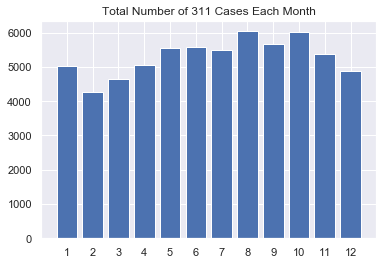

In [28]:
plt.bar(x=range(1,13), height='total', data=month_counts )
plt.xticks(range(1, 13))
plt.title('Total Number of 311 Cases Each Month')
plt.show()

In [29]:
month_counts_new = month_counts.iloc[:, :-1].div(month_counts['total'], axis=0) * 100

month_counts_new.reset_index(inplace=True)
month_counts_new

group,month,Bulky Items,Damaged Property,Encampments,General Cleaning,Graffiti,Hazardous Materials,Human or Medical Waste,Litter Receptacles,Other,Rec and Park Requests,Sewer Issues,Signs - Illegal Postings and Repair,Street and Sidewalk Issues,Streetlights,Tree Maintenance,Vehicle
0,1,15.691331,1.110891,8.787939,19.996033,27.177147,0.972029,5.971037,3.769093,1.130728,1.825035,0.932355,3.114461,3.570720,0.912517,2.281293,2.757389
1,2,15.638149,1.238897,8.555400,18.186068,27.302478,1.566152,6.474988,4.137447,1.379149,1.706405,0.654511,3.015428,4.043946,0.701262,1.706405,3.693315
2,3,14.291845,1.137339,11.137339,17.103004,25.944206,1.008584,6.888412,4.055794,1.309013,1.781116,0.922747,3.025751,4.248927,1.094421,1.866953,4.184549
3,4,14.265901,1.347335,11.888250,18.288092,22.349911,1.327521,6.142263,3.447593,2.219140,1.941748,0.812364,2.555974,4.458094,0.534971,1.684169,6.736675
4,5,15.381844,1.188761,12.968300,16.948847,17.723343,1.512968,6.610231,3.998559,2.431556,2.017291,0.666427,2.863833,3.530259,0.612392,1.891210,9.654179
5,6,15.452261,1.435750,12.832017,17.067480,18.521177,1.381910,6.317301,4.702082,2.153625,2.027997,0.574300,3.786791,3.643216,0.412778,1.758794,7.932520
6,7,14.905592,1.379811,14.542484,17.683370,16.920842,1.543210,7.225853,4.793028,2.305737,1.833696,0.526507,2.596224,3.703704,0.472041,1.761075,7.806826
7,8,15.756372,1.092354,14.233697,17.510758,15.690169,1.539225,8.076796,4.617676,2.962595,1.655081,0.479974,2.714333,2.995697,0.579278,1.770937,8.325058
8,9,14.787365,0.899947,13.905064,16.728428,15.510852,1.746956,8.275984,4.570319,3.617434,1.588142,0.882301,3.388036,3.723310,0.723487,1.411682,8.240692
9,10,14.492272,0.914077,13.561576,17.949144,13.146086,1.911251,10.453714,4.719960,4.071797,1.495762,0.631544,2.908426,3.074622,0.432109,1.628719,8.608941


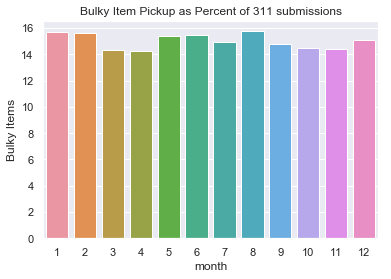

In [30]:
sns.barplot(x='month', 
            y='Bulky Items', 
            data=month_counts_new)
plt.title('Bulky Item Pickup as Percent of 311 submissions')
plt.show()

Overall, there are fewer cases in the dataset for February, but there is an increase in percent of Bulky Items.  Perhaps this is due to spring cleaning?

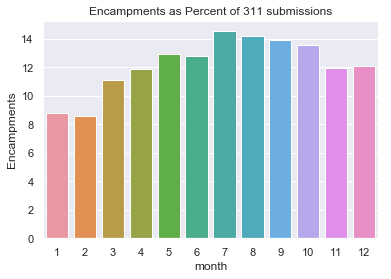

In [31]:
sns.barplot(x='month', 
            y='Encampments', 
            data=month_counts_new)
plt.title('Encampments as Percent of 311 submissions')
plt.show()

The higher proportion of encapments during the summer may be due to the better weather.

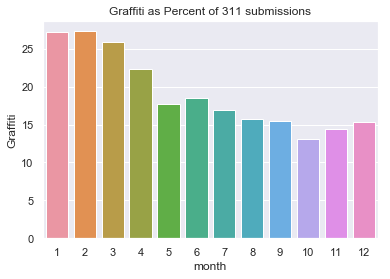

In [32]:
sns.barplot(x='month', 
            y='Graffiti', 
            data=month_counts_new)
plt.title('Graffiti as Percent of 311 submissions')
plt.show()

Maybe there is a campaign against graffiti in the Spring? Or it could be due to an increase of the percent of other complaints.  Since this is surprising to me, I will next look at the number of graffiti complaints.

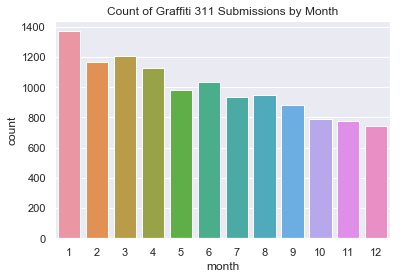

In [33]:
graffiti = pd.DataFrame({'month': range(1,13), 
                        'count': month_counts['Graffiti']})
sns.barplot(x='month', 
            y='count', 
            data=graffiti)
plt.title('Count of Graffiti 311 Submissions by Month')
plt.show()

Interesting, the number of graffiti cases also decreases from January to December. 

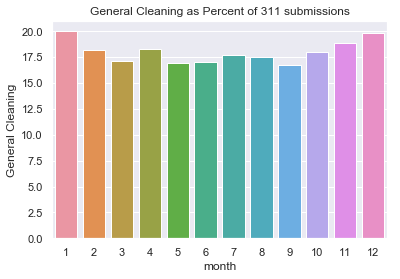

In [34]:
sns.barplot(x='month', 
            y='General Cleaning', 
            data=month_counts_new)
plt.title('General Cleaning as Percent of 311 submissions')
plt.show()

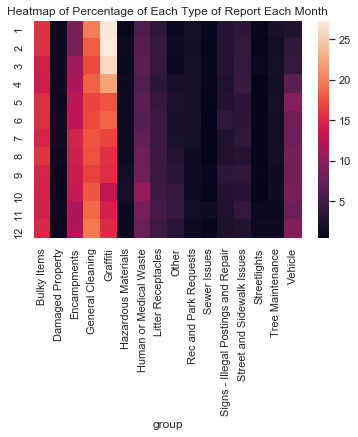

In [41]:
sns.heatmap(month_counts_new.iloc[:, 1:], yticklabels=range(1, 13))
plt.title('Heatmap of Percentage of Each Type of Report Each Month')
plt.show()

# Modeling Using Categorical Variables

### Selected Features

In [42]:
# Store the features used for modeling
features = ['month', 'neighborhood', 'street']

### Training and test data sets

In [43]:
X = df[features].copy()
y = df['group'].copy()

le_month = LabelEncoder()
le_neigh = LabelEncoder()
le_street = LabelEncoder()
le_group = LabelEncoder()

X['month'] = le_month.fit_transform(X['month'])
X['neighborhood'] = le_neigh.fit_transform(X['neighborhood'])
X['street'] = le_street.fit_transform(X['street'])
y = le_group.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y,
                                                   test_size=0.25,
                                                   random_state=42)

### Random Forest Classifier
Random forests handle categorical label encoded data reasonably well without one-hot encoding

In [ ]:
parameters = {'max_features': range(1,3),
              'n_estimators': [50, 100, 200, 300, 400, 500],
              'min_samples_leaf': [10,50,100,200,500]}

cv = GridSearchCV(rfc, parameters, cv = 5)
cv.fit(X_train, y_train)

In [ ]:
cv.best_params_

Training Set Score: 0.406
Test Set Score: 0.309


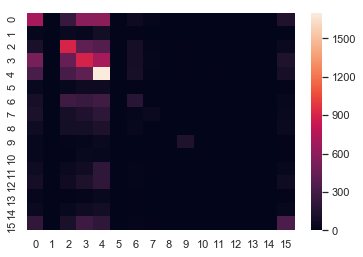

In [44]:
# Initiate a Random Forest Class
rfc = RandomForestClassifier(max_features=2,
                             min_samples_leaf=10,
                             n_estimators=500)

# Fit the Model
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Look at the score for the training under sampled data
y_train_pred = rfc.predict(X_train)
print('Training Set Score: {:.3f}'.format(rfc.score(X_train, y_train)))
print('Test Set Score: {:.3f}'.format(rfc.score(X_test, y_test)))

confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion)
plt.show()

In [ ]:
print(le_group.inverse_transform([0, 2, 3, 4, 6, 9, 15]))

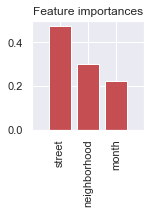

In [45]:
# Plot the feature importances
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(2,2))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.show()

# Using One-Hot Encoding

In [46]:
X_ohe = df[features].copy()
y_le = df['group'].copy()

ohe = OneHotEncoder()
#ohe_neigh = LabelEncoder()
#ohe_street = LabelEncoder()
le_group = LabelEncoder()

X_ohe = ohe.fit_transform(X_ohe)
#X_ohe['neighborhood'] = le_neigh.fit_transform(X['neighborhood'])
#X_ohe['street'] = le_street.fit_transform(X['street'])
y = le_group.fit_transform(y_le)

X_ohe_train, X_ohe_test, y_train, y_test = train_test_split(X_ohe, 
                                                            y_le,
                                                            test_size=0.25,
                                                            random_state=42)

In [ ]:
parameters = {'max_features': [10, 50, 200, 300, 500, 1000],
              'n_estimators': [50, 200, 400, 500],
              'min_samples_leaf': [10, 50, 100]}

cv = GridSearchCV(rfc, parameters, cv = 5)
cv.fit(X_ohe_train, y_train)

In [ ]:
cv.best_params_

Training Set Score: 0.351
Test Set Score: 0.310


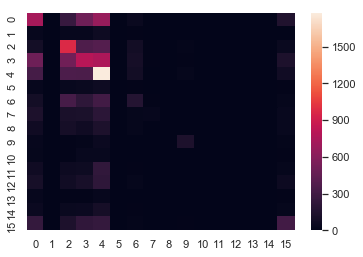

In [47]:
# Initiate a Random Forest Class
rfc_ohe = RandomForestClassifier(max_features=300,
                                 min_samples_leaf=10,
                                 n_estimators=400)

# Fit the Model
rfc_ohe.fit(X_ohe_train, y_train)
y_pred_ohe = rfc_ohe.predict(X_ohe_test)

# Look at the score for the training under sampled data
y_ohe_train_pred = rfc_ohe.predict(X_ohe_train)
print('Training Set Score: {:.3f}'.format(rfc_ohe.score(X_ohe_train, y_train)))
print('Test Set Score: {:.3f}'.format(rfc_ohe.score(X_ohe_test, y_test)))

confusion = confusion_matrix(y_test, y_pred_ohe)
sns.heatmap(confusion)
plt.show()

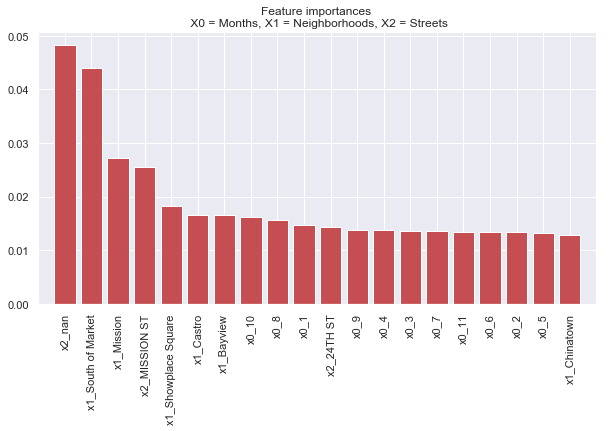

In [48]:
# Plot the feature importances
importances = rfc_ohe.feature_importances_
indices = np.argsort(importances)[::-1][0:20]

# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Feature importances \n X0 = Months, X1 = Neighborhoods, X2 = Streets")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), ohe.get_feature_names()[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.show()

### For modeling with Keras, feature selection on one hot encoding

In [62]:
# For boolean Var[X] = p(1-p)
# Remove all features that are either 1 or 0 in more than 99% of
# the samples
sel = VarianceThreshold(threshold=(.9995 * (1-.9995)))
X_sel_train = sel.fit_transform(X_ohe_train)
X_sel_test = sel.transform(X_ohe_test)

In [63]:
X_ohe_train.shape

(47725, 1855)

In [64]:
X_sel_train.shape

(47725, 476)

In [65]:
sel.get_support

<bound method SelectorMixin.get_support of VarianceThreshold(threshold=0.000499749999999945)>

In [66]:
# Features selected by the variance threshold
features_sel = ohe.get_feature_names()[sel.get_support(indices=True)]

In [67]:
features_sel

array(['x0_1', 'x0_2', 'x0_3', 'x0_4', 'x0_5', 'x0_6', 'x0_7', 'x0_8',
       'x0_9', 'x0_10', 'x0_11', 'x0_12', 'x1_Alamo Square',
       'x1_Anza Vista', 'x1_Apparel City', 'x1_Aquatic Park / Ft. Mason',
       'x1_Ashbury Heights', 'x1_Bayview', 'x1_Bernal Heights',
       'x1_Bret Harte', 'x1_Buena Vista', 'x1_Castro',
       'x1_Cathedral Hill', 'x1_Cayuga', 'x1_Central Waterfront',
       'x1_Chinatown', 'x1_Civic Center', 'x1_Clarendon Heights',
       'x1_Cole Valley', 'x1_Corona Heights', 'x1_Cow Hollow',
       'x1_Crocker Amazon', 'x1_Diamond Heights', 'x1_Dogpatch',
       'x1_Dolores Heights', 'x1_Downtown / Union Square',
       'x1_Duboce Triangle', 'x1_Eureka Valley', 'x1_Excelsior',
       'x1_Fairmount', 'x1_Financial District', "x1_Fisherman's Wharf",
       'x1_Forest Hill', 'x1_Forest Knolls', 'x1_Glen Park',
       'x1_Golden Gate Heights', 'x1_Golden Gate Park',
       'x1_Haight Ashbury', 'x1_Hayes Valley', 'x1_Holly Park',
       'x1_Hunters Point', 'x1_India B

In [68]:
sel_k = SelectKBest(chi2, k=200)
X_sel_k = sel_k.fit_transform(X_sel_train, y_train)
X_sel_k_test = sel_k.transform(X_sel_test)

In [69]:
features_sel_k = features_sel[sel_k.get_support(indices=True)]
print(features_sel_k)

['x0_1' 'x0_2' 'x0_3' 'x0_4' 'x0_8' 'x0_9' 'x0_10' 'x0_11' 'x0_12'
 'x1_Alamo Square' 'x1_Apparel City' 'x1_Ashbury Heights' 'x1_Bayview'
 'x1_Bernal Heights' 'x1_Bret Harte' 'x1_Buena Vista' 'x1_Castro'
 'x1_Cathedral Hill' 'x1_Cayuga' 'x1_Chinatown' 'x1_Civic Center'
 'x1_Cole Valley' 'x1_Corona Heights' 'x1_Dogpatch'
 'x1_Downtown / Union Square' 'x1_Duboce Triangle' 'x1_Excelsior'
 'x1_Financial District' 'x1_Forest Hill' 'x1_Forest Knolls'
 'x1_Glen Park' 'x1_Golden Gate Heights' 'x1_Golden Gate Park'
 'x1_Haight Ashbury' 'x1_Holly Park' 'x1_Hunters Point' 'x1_India Basin'
 'x1_Ingleside' 'x1_Inner Richmond' 'x1_Inner Sunset' 'x1_Lake Street'
 'x1_Lower Haight' 'x1_Lower Nob Hill' 'x1_Marina' 'x1_McLaren Park'
 'x1_Merced Heights' 'x1_Miraloma Park' 'x1_Mission' 'x1_Mission Bay'
 'x1_Mission Dolores' 'x1_Mission Terrace' 'x1_Nob Hill' 'x1_Noe Valley'
 'x1_North Beach' 'x1_Oceanview' 'x1_Outer Richmond' 'x1_Outer Sunset'
 'x1_Panhandle' 'x1_Parkside' 'x1_Peralta Heights' 'x1_Portol

Training Set Score: 0.312
Test Set Score: 0.293


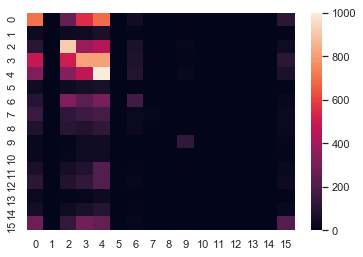

In [78]:
# Initiate a Random Forest Class
rfc_sel = RandomForestClassifier(max_features=50,
                                 min_samples_leaf=20,
                                 n_estimators=400)

# Fit the Model
rfc_sel.fit(X_sel_k, y_train)
y_pred_sel = rfc_sel.predict(X_sel_k_test)

# Look at the score for the training under sampled data
y_sel_train_pred = rfc_sel.predict(X_sel_k)
print('Training Set Score: {:.3f}'.format(rfc_sel.score(X_sel_k, y_train)))
print('Test Set Score: {:.3f}'.format(rfc_sel.score(X_sel_k_test, y_test)))

confusion = confusion_matrix(y_test, y_pred_sel)
sns.heatmap(confusion, vmin=0, vmax=1000)
plt.show()

We lose a little accuracy with the random forest classifier when we limit it to 200 features, but this may be worthwhile when we move to creating a model combining these features and the images. The model with the images will already consume a large amount of memory, and I will need to optimize that where I can.